In [36]:
import pandas as pd

import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,OrdinalEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import xgboost as xgb


# 1. Data Source and Contents

In [3]:
df = pd.read_csv("census_data.csv")

In [4]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   hours_per_week_bin  48842 non-null  object
 1   occupation_bin      48842 non-null  object
 2   msr_bin             48842 non-null  object
 3   capital_gl_bin      48842 non-null  object
 4   race_sex_bin        48842 non-null  object
 5   education_num_bin   48842 non-null  object
 6   education_bin       48842 non-null  object
 7   workclass_bin       48842 non-null  object
 8   age_bin             48842 non-null  object
 9   flag                48842 non-null  object
 10  y                   48842 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 4.1+ MB


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0


In [5]:
#Check for any missing values
df.isna().sum()/len(df)*100

,0
hours_per_week_bin,0.0
occupation_bin,0.0
msr_bin,0.0
capital_gl_bin,0.0
race_sex_bin,0.0
education_num_bin,0.0
education_bin,0.0
workclass_bin,0.0
age_bin,0.0
flag,0.0


In [6]:
# change the type of column "y" because 0 and 1 in this case are categories, it does not have a numerical meaning
df["y"]=df["y"].astype('category')

# general data description
# "include" argument says that we should include columns with string/object and category data types
df.describe(include=['O','category'])

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
count,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,5,5,3,3,3,5,5,2,5,2,2
top,b. 31-40,c. Mid - Mid,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,0
freq,26639,13971,22047,42525,29737,30324,30324,46012,13963,32561,37155


In [7]:
# we want to get rid of the preceeding letters (i.e. "a. ", "b. ", etc.)
# all columns except "flag" and "y" have preceeding letters
for col in df.drop(columns=["flag","y"]): # for all columns except "flag" and "y"
    df[col] = df[col].str.split(". ", n=1, expand=True)[1] # split each value and only take the second element

In [8]:
df.head()

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,31-40,Mid - Low,Mid,> 0,High,13,Bachelors,income,36-40 & 56-60,train,0
1,0-30,High,High,= 0,High,13,Bachelors,income,40-55,train,0
2,31-40,Low,Mid,= 0,High,9-12,Mid,income,36-40 & 56-60,train,0
3,31-40,Low,High,= 0,Mid,0-8,Low,income,40-55,train,0
4,31-40,High,High,= 0,Low,13,Bachelors,income,26-30 & 71-100,train,0


# Exploratory Data Analysis

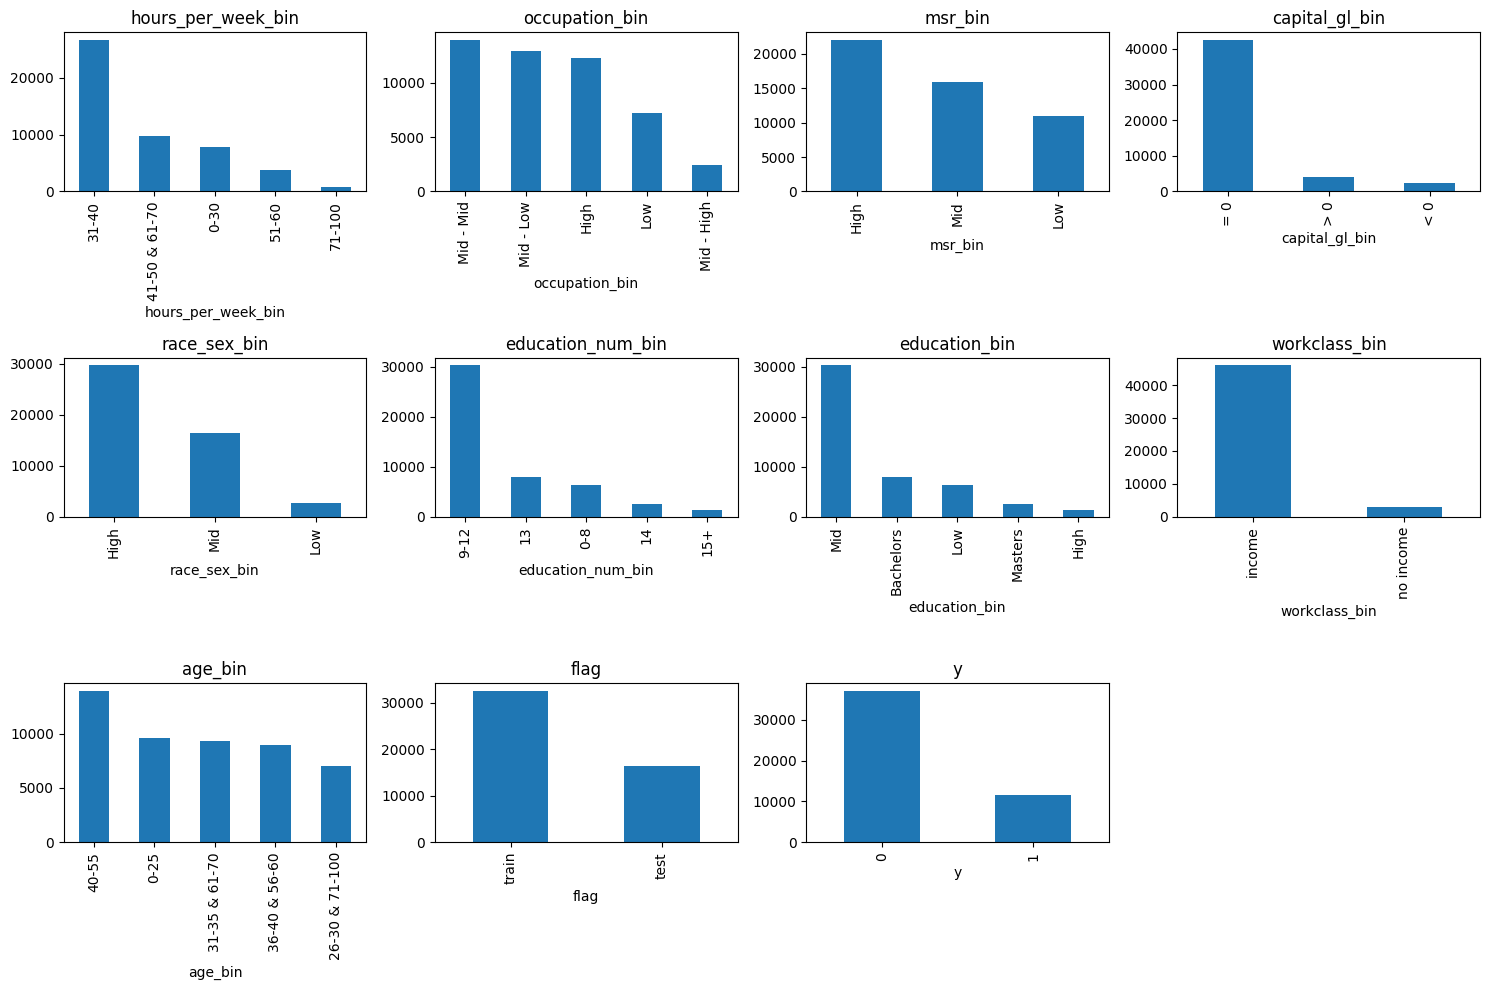

In [9]:
#visualize our columns
rows = 3
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(15,10))
axes = axes.flatten()

for i, column in enumerate(df.columns):
    df[column].value_counts().plot(kind='bar', ax=axes[i], title=column)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

<ipython-input-10-bfc317cb24ab>:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table_var = pd.pivot_table(data=df, index=col, columns="y", aggfunc="count")["flag"]
<ipython-input-10-bfc317cb24ab>:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table_var = pd.pivot_table(data=df, index=col, columns="y", aggfunc="count")["flag"]
<ipython-input-10-bfc317cb24ab>:18: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table_var = pd.pivot_table(data=df, index=col, columns="y", aggfunc="count")["flag"]
<ipytho

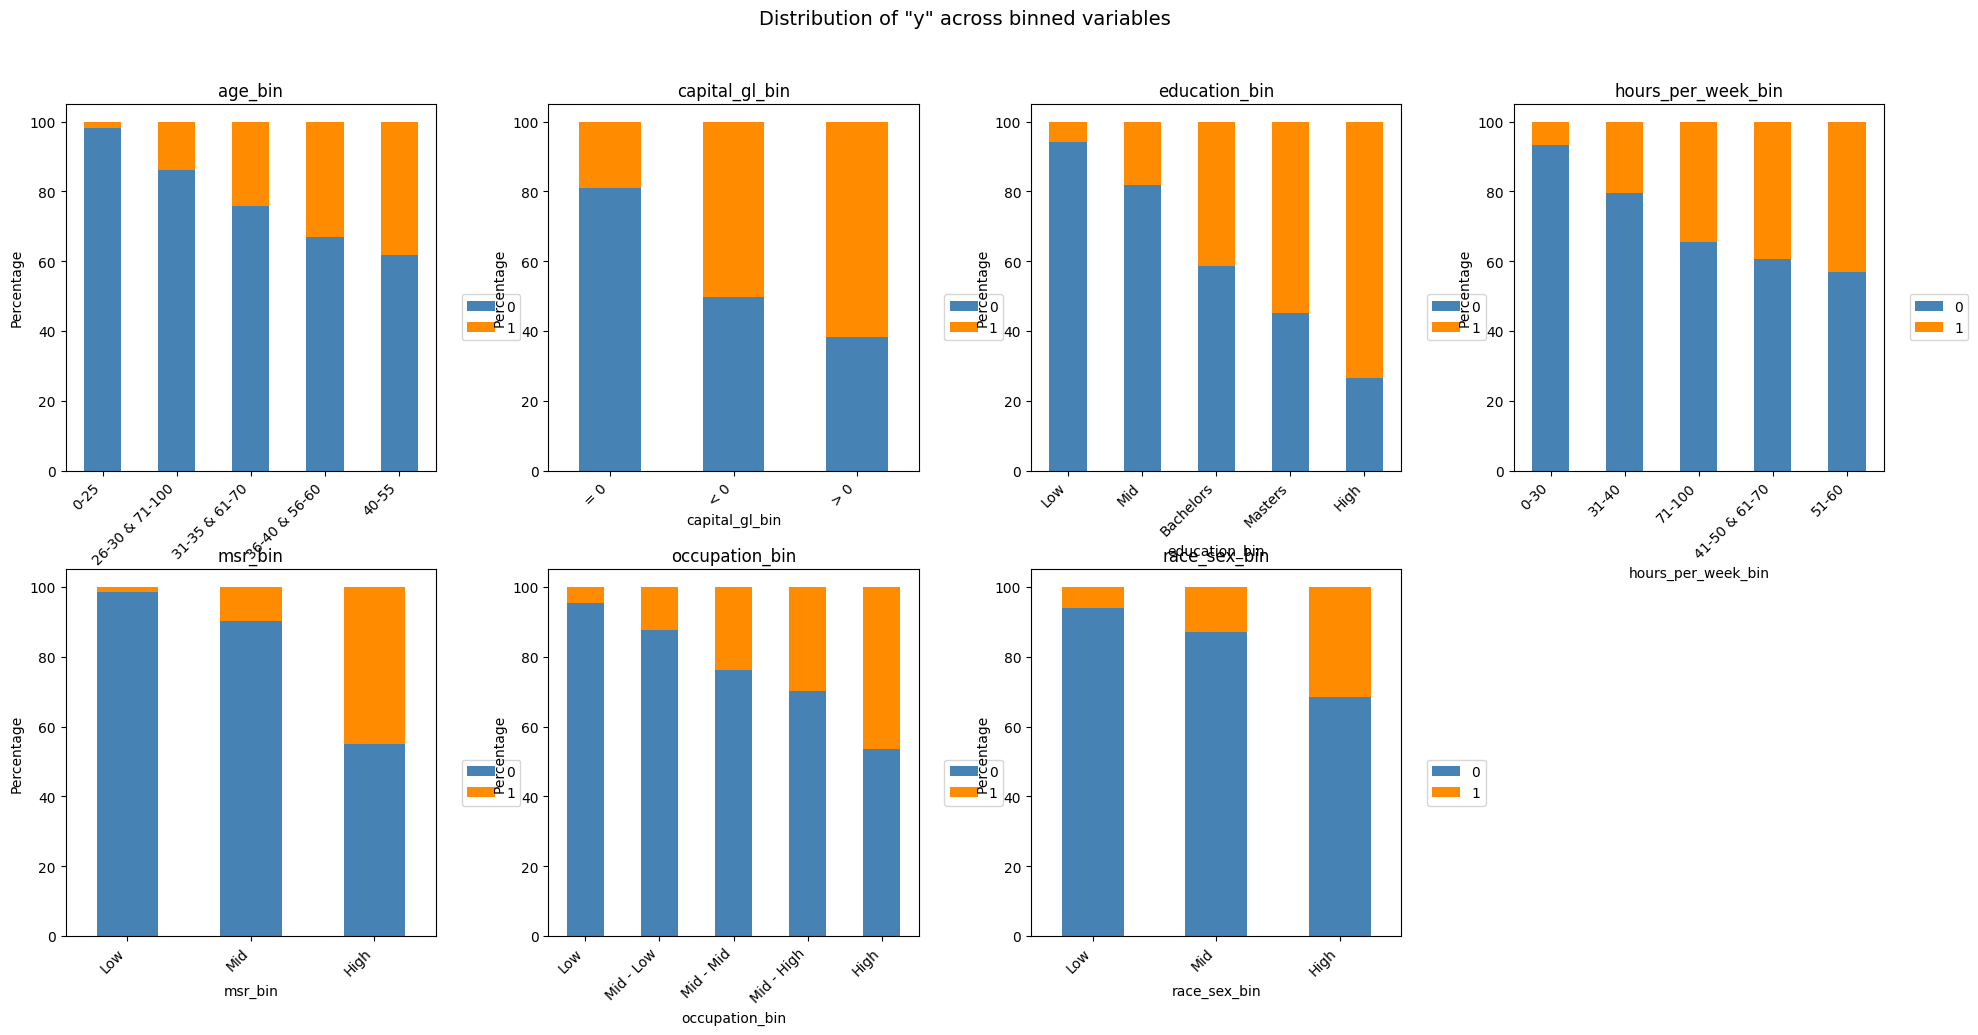

In [10]:
# Plot Distribution of "y" across binned variables
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.tight_layout(pad=5.0)
fig.suptitle('Distribution of "y" across binned variables', y=1.02, fontsize=14)


columns_to_plot = ["age_bin", "capital_gl_bin", "education_bin",
                  "hours_per_week_bin", "msr_bin", "occupation_bin",
                  "race_sex_bin"]

# Flatten the axes array for easy iteration
axes = axes.flatten()

for idx, col in enumerate(columns_to_plot):
    ax = axes[idx]

    # Create the pivot table
    table_var = pd.pivot_table(data=df, index=col, columns="y", aggfunc="count")["flag"]
    table_var = table_var.div(table_var.sum(axis=1), axis=0).apply(lambda x: x*100).sort_values(by=[1])

    # Plot on the current subplot axis
    table_var.plot.bar(stacked=True, color=['steelblue','darkorange'], ax=ax)

    ax.set_title(col)
    ax.legend(bbox_to_anchor=(1.05, 0.5))
    ax.set_ylabel('Percentage')

    # Rotate x-labels if needed
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

# Hide the empty subplot (8th one)
axes[-1].axis('off')

plt.show()

In [11]:
#data quality report
categorical = df.select_dtypes(include=object)
cols = ['%Missing','Count', 'Mode', 'Cardinality' ]
categorical_dqr = pd.DataFrame(columns=cols, index=categorical.columns)

for col in categorical.columns:
    column_data = categorical[col]
    count = column_data.count()
    missing = column_data.isna().sum()/len(categorical)*100
    cardinality = column_data.nunique()
    mode = column_data.mode().iloc[0]
    categorical_dqr.loc[col, ['%Missing','Count', 'Mode', 'Cardinality' ]] = [count, missing, cardinality, mode]
categorical_dqr

,Count,%Missing,Cardinality,Mode
hours_per_week_bin,48842,0.0,5,31-40
occupation_bin,48842,0.0,5,Mid - Mid
msr_bin,48842,0.0,3,High
capital_gl_bin,48842,0.0,3,= 0
race_sex_bin,48842,0.0,3,High
education_num_bin,48842,0.0,5,9-12
education_bin,48842,0.0,5,Mid
workclass_bin,48842,0.0,2,income
age_bin,48842,0.0,5,40-55
flag,48842,0.0,2,train


# Encoding variables

In [12]:
ordinal_cols = ["education_num_bin", "hours_per_week_bin", "capital_gl_bin", "age_bin"]

encoder_ordinal = OrdinalEncoder(dtype='int32')

df[ordinal_cols] = encoder_ordinal.fit_transform(df[ordinal_cols])

In [13]:
one_hot_cols = ["education_bin", "occupation_bin", "msr_bin", "race_sex_bin", "workclass_bin"]

df = pd.get_dummies(df, columns=one_hot_cols,drop_first=True,dtype='int32')

df

,hours_per_week_bin,capital_gl_bin,education_num_bin,age_bin,flag,y,education_bin_High,education_bin_Low,education_bin_Masters,education_bin_Mid,occupation_bin_Low,occupation_bin_Mid - High,occupation_bin_Mid - Low,occupation_bin_Mid - Mid,msr_bin_Low,msr_bin_Mid,race_sex_bin_Low,race_sex_bin_Mid,workclass_bin_no income
0,1,2,1,3,train,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,0,1,1,4,train,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,4,3,train,0,0,0,0,1,1,0,0,0,0,1,0,0,0
3,1,1,0,4,train,0,0,1,0,0,1,0,0,0,0,0,0,1,0
4,1,1,1,1,train,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,1,1,1,3,test,0,0,0,0,0,0,0,0,0,0,1,0,1,0
48838,1,1,4,2,test,0,0,0,0,1,0,0,1,0,1,0,0,1,1
48839,2,1,1,3,test,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48840,1,2,1,4,test,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   hours_per_week_bin         48842 non-null  int32   
 1   capital_gl_bin             48842 non-null  int32   
 2   education_num_bin          48842 non-null  int32   
 3   age_bin                    48842 non-null  int32   
 4   flag                       48842 non-null  object  
 5   y                          48842 non-null  category
 6   education_bin_High         48842 non-null  int64   
 7   education_bin_Low          48842 non-null  int64   
 8   education_bin_Masters      48842 non-null  int64   
 9   education_bin_Mid          48842 non-null  int64   
 10  occupation_bin_Low         48842 non-null  int64   
 11  occupation_bin_Mid - High  48842 non-null  int64   
 12  occupation_bin_Mid - Low   48842 non-null  int64   
 13  occupation_bin_Mid - Mid   4884

## Split the data

In [18]:
x_train = df[df['flag'] == 'train'].drop(columns=['flag','y'])
x_test = df[df['flag'] == 'test'].drop(columns=['flag','y'])

y_train = df[df['flag']=='train']['y']
y_test = df[df['flag']=='test']['y']


# 2. Finding Optimal Value of a key Ensemble Method Hyper-parameter

# 3. Building a Random Forest Model

In [21]:
randforest = RandomForestClassifier()
randforest.fit(x_train, y_train)
y_pred=randforest.predict(x_test)



# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# AUC
auc = roc_auc_score(y_test, y_pred)
print("AUC:", auc)

# Precision
precision = precision_score(y_test, y_pred)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_pred)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

Confusion Matrix:
 [[11419  1016]
 [ 1635  2211]]
Accuracy: 0.837172163871998
AUC: 0.7465890650101277
Precision: 0.6851564920979237
Recall: 0.5748829953198128
F1 Score: 0.6251944012441679


In [26]:
# Initializing lists to store results
results = []

n_estimators_options =[50,100,150,200,250,300,350,400,450,500]

for n in n_estimators_options:
    rf_model = RandomForestClassifier(n_estimators=n,random_state=42)
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)
    y_prob = rf_model.predict_proba(x_test)[:, 1]  # Probability for positive class

    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results.append((n, accuracy, auc))

# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['n_estimators', 'Accuracy', 'AUC'])

print(results_df)

   n_estimators  Accuracy       AUC
0            50  0.837664  0.879816
1           100  0.838093  0.880780
2           150  0.836619  0.881244
3           200  0.837418  0.881246
4           250  0.837049  0.881601
5           300  0.837786  0.881697
6           350  0.837786  0.881669
7           400  0.836742  0.881594
8           450  0.836435  0.881597
9           500  0.837049  0.881561


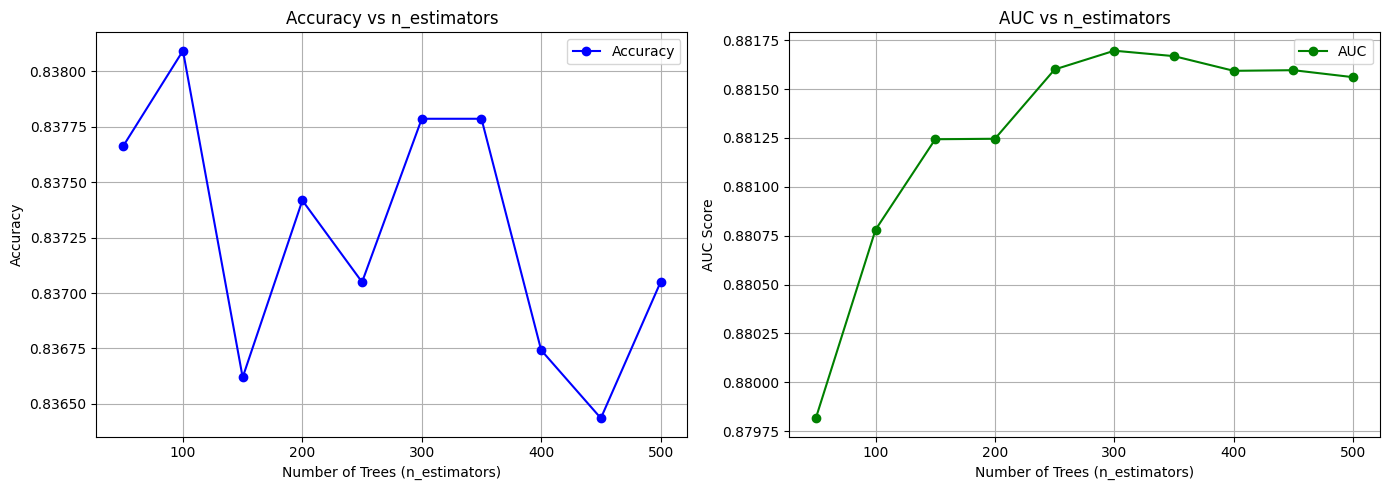

In [27]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy on left subplot
ax1.plot(results_df['n_estimators'], results_df['Accuracy'],
         marker='o', color='blue', linestyle='-', label='Accuracy')
ax1.set_title('Accuracy vs n_estimators')
ax1.set_xlabel('Number of Trees (n_estimators)')
ax1.set_ylabel('Accuracy')
ax1.grid(True)
ax1.legend()

# Plot AUC on right subplot
ax2.plot(results_df['n_estimators'], results_df['AUC'],
         marker='o', color='green', linestyle='-', label='AUC')
ax2.set_title('AUC vs n_estimators')
ax2.set_xlabel('Number of Trees (n_estimators)')
ax2.set_ylabel('AUC Score')
ax2.grid(True)
ax2.legend()

# Adjust layout and display
plt.tight_layout()
plt.show()

### 1) Observations :
  Number of estimators has a more impactful effect on accuracy than it does on AUC. For accuracy, when you increase the n_estimators to 100, you hit the maximum accuracy, and then it proceeds to (almost) oscillate but not get back to its max height. When looking at AUC, the AUC steadily increases as the n_estimators increases. AUC hits its peak at about 300 estimators, then it gradually declines.

### 2) Optimal Value ?
  Overall, we might want to choose n_estimators to be around 300 because that's peak AUC and appears to be a stable point for accuracy.


# Building Adaboost, Gradient Boost, and XGB

##AdaBoost Classfier

In [28]:
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(x_train, y_train)
y_pred = adaboost.predict(x_test)

# Evaluation Metrics
print("\n=== AdaBoost ===")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


=== AdaBoost ===
Confusion Matrix:
 [[11485   950]
 [ 1688  2158]]
Accuracy: 0.8379706406240403
AUC: 0.7423525891578486
Precision: 0.6943371943371943
Recall: 0.5611024440977639
F1 Score: 0.6206499856197871


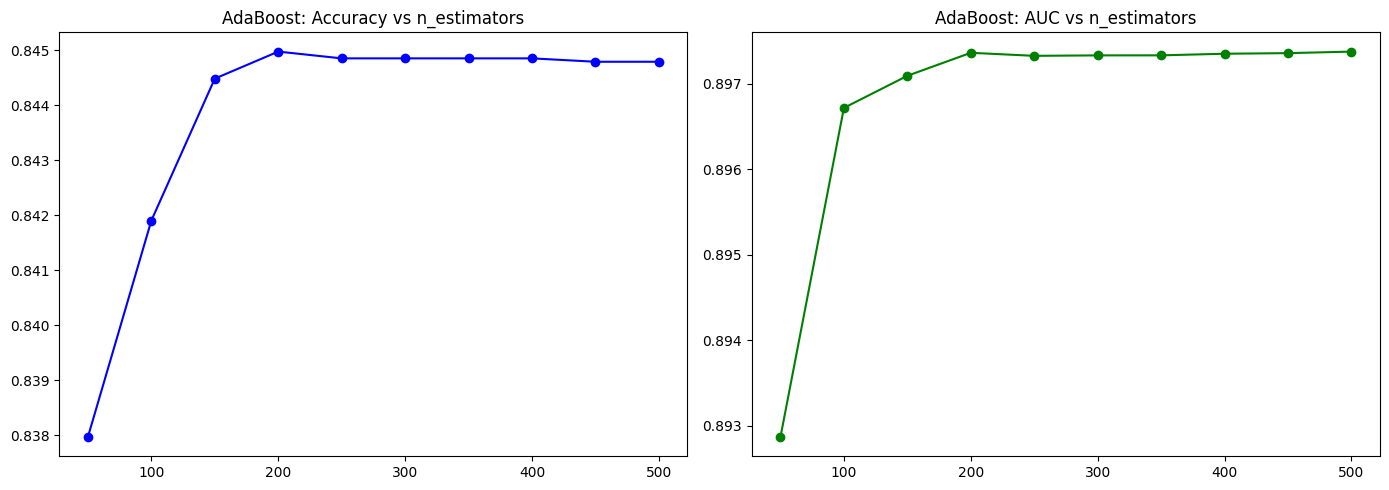

In [30]:
# n_estimators tuning
ada_results = []
for n in n_estimators_options:
    model = AdaBoostClassifier(n_estimators=n, random_state=42)
    model.fit(x_train, y_train)
    y_prob = model.predict_proba(x_test)[:, 1]
    ada_results.append((n,accuracy_score(y_test, model.predict(x_test)),roc_auc_score(y_test, y_prob)))

ada_results_df = pd.DataFrame(ada_results, columns=['n_estimators', 'Accuracy', 'AUC'])

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(ada_results_df['n_estimators'], ada_results_df['Accuracy'], marker='o', color='blue')
ax1.set_title('AdaBoost: Accuracy vs n_estimators')
ax2.plot(ada_results_df['n_estimators'], ada_results_df['AUC'], marker='o', color='green')
ax2.set_title('AdaBoost: AUC vs n_estimators')
plt.tight_layout()
plt.show()

### 1) Observations :
  Number of estimators has a seemingly equivalent effect on both accuracy and AUC. It seems like there is a minimum threshold for n_estimators where accuracy can reach close to its peak. When looking at Accuracy vs n_estimators [on the left], we see that accuracy reaches its peak at about 200 estimators. When looking at AUC vs n_estimators [on the right], we see that AUC also reaches its peak at about 200 estimators.

### 2) Optimal Value ?
  There does seem to be an optimal value for the ADABoost Classifier. We can optimize accuracy and AUC by setting n_estimators = 200.


## Gradient Boost Classifier

In [31]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(x_train, y_train)
y_pred = gbc.predict(x_test)

# Evaluation Metrics
print("\n=== Gradient Boosting ===")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))




=== Gradient Boosting ===
Confusion Matrix:
 [[11548   887]
 [ 1614  2232]]
Accuracy: 0.8463853571647934
AUC: 0.7545061464702255
Precision: 0.7156139788393716
Recall: 0.5803432137285491
F1 Score: 0.64091888011486


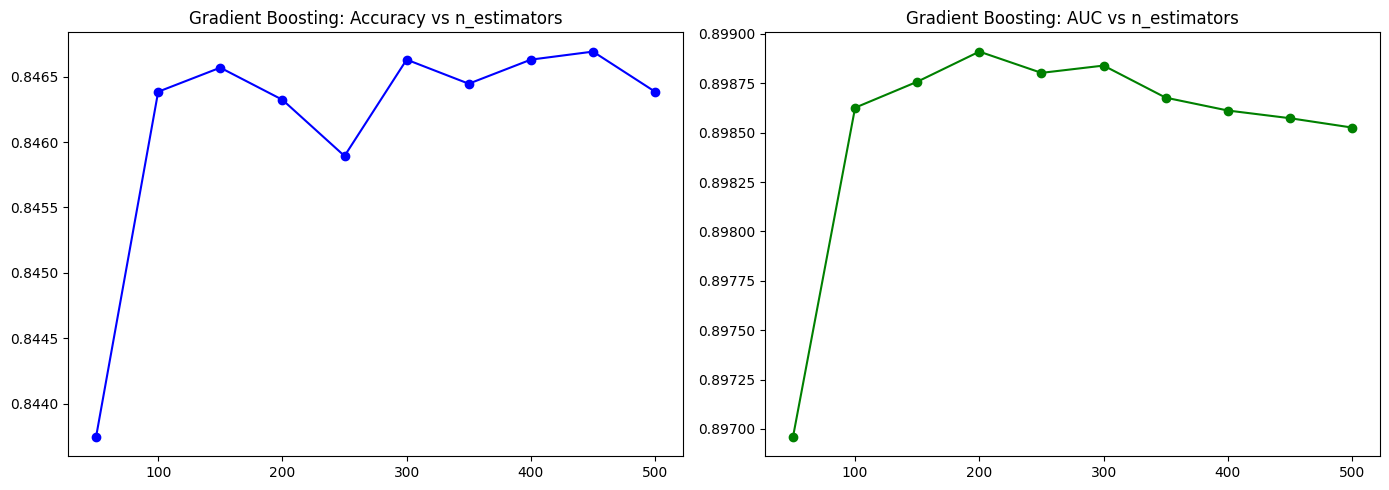

In [33]:
# n_estimators tuning
gbc_results = []
for n in n_estimators_options:
    model = GradientBoostingClassifier(n_estimators=n, random_state=42)
    model.fit(x_train, y_train)
    y_prob = model.predict_proba(x_test)[:, 1]
    gbc_results.append((n,
                        accuracy_score(y_test, model.predict(x_test)),
                        roc_auc_score(y_test, y_prob)))

gbc_results_df = pd.DataFrame(gbc_results, columns=['n_estimators', 'Accuracy', 'AUC'])

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(gbc_results_df['n_estimators'], gbc_results_df['Accuracy'], marker='o', color='blue')
ax1.set_title('Gradient Boosting: Accuracy vs n_estimators')
ax2.plot(gbc_results_df['n_estimators'], gbc_results_df['AUC'], marker='o', color='green')
ax2.set_title('Gradient Boosting: AUC vs n_estimators')
plt.tight_layout()
plt.show()

### 1) Observations :
  On the left [accuracy vs n_estimators] we see that accuracy tends to improve as the n_estimators increases, with a max accuracy value at about 450 estimators. On the right, we see that AUC improves as n_estimators increases to about 200, then it is a gradual decline.

### 2) Optimal Value ?
  The optimal value is probably at 100 to 150 estimators. Accuracy reaches one of its peaks at 150 estimators and AUC is at a solid spot. We could consider going above 250 estimators, but Accuracy has its min at 250 estimators, and AUC starts to decline after about 300 estimators.

## XGB Classfier

In [40]:
xgb_ = xgb.XGBClassifier(random_state=42)
xgb_.fit(x_train, y_train)
y_pred = xgb_.predict(x_test)

# Evaluation Metrics
print("\n=== XGBoost ===")
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))


=== XGBoost ===
Confusion Matrix:
 [[11437   998]
 [ 1539  2307]]
Accuracy: 0.8441741907745225
AUC: 0.7597933278006632
Precision: 0.6980332829046899
Recall: 0.5998439937597504
F1 Score: 0.6452244441336876


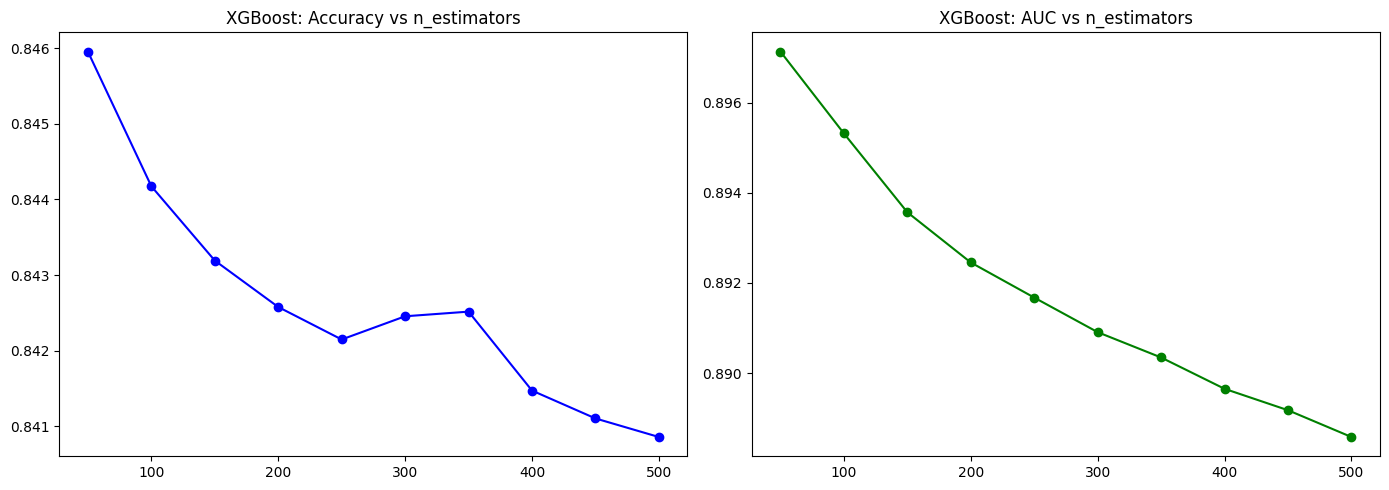

In [42]:

# n_estimators tuning
xgb_results = []
for n in n_estimators_options:
    model = xgb.XGBClassifier(n_estimators=n, random_state=42)
    model.fit(x_train, y_train)
    y_prob = model.predict_proba(x_test)[:, 1]
    xgb_results.append((n,
                        accuracy_score(y_test, model.predict(x_test)),
                        roc_auc_score(y_test, y_prob)))

xgb_results_df = pd.DataFrame(xgb_results, columns=['n_estimators', 'Accuracy', 'AUC'])

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.plot(xgb_results_df['n_estimators'], xgb_results_df['Accuracy'], marker='o', color='blue')
ax1.set_title('XGBoost: Accuracy vs n_estimators')
ax2.plot(xgb_results_df['n_estimators'], xgb_results_df['AUC'], marker='o', color='green')
ax2.set_title('XGBoost: AUC vs n_estimators')
plt.tight_layout()
plt.show()

### 1) Observations :
 For XGBoost Classifiers, increasing the number of estimators decreases both accuracy and AUC. When we look at the accuracy and AUC of a XGBoost model with default hyper-parameters we have an accuracy of 0.844 and an AUC of 0.760. As soon as you have more than 50 estimators, accuracy below 0.846. The interesting observation is that AUC starts at about 0.898 with 50 estimators but we don't ever see it reach anywhere near 0.760, so I wonder what other default hyper-parameters are affecting the XGBoost.

### 2) Optimal Value ?
  The optimal value here is to minimize n_estimators. Let's say 10 estimators.

# Compare Performance

In [52]:
compare_df = pd.DataFrame({
    'Model': ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'XGBoost'],
    'n_estimators': [300, 200, 125, 10],
    'Accuracy': [
        results_df[results_df['n_estimators'] == 300]['Accuracy'].values[0],
        ada_results_df[ada_results_df['n_estimators'] == 200]['Accuracy'].values[0],
        gbc_results_df[gbc_results_df['n_estimators'] == 150]['Accuracy'].values[0],
        xgb_results_df[xgb_results_df['n_estimators'] == 50]['Accuracy'].values[0]
    ],
    'AUC': [
        results_df[results_df['n_estimators'] == 300]['AUC'].values[0],
        ada_results_df[ada_results_df['n_estimators'] == 200]['AUC'].values[0],
        gbc_results_df[gbc_results_df['n_estimators'] == 150]['AUC'].values[0],
        xgb_results_df[xgb_results_df['n_estimators'] == 50]['AUC'].values[0]
    ]
})
compare_df= compare_df.sort_values(by="Accuracy",ascending=False)
compare_df

,Model,n_estimators,Accuracy,AUC
2,Gradient Boosting,125,0.846570,0.898758
3,XGBoost,10,0.845955,0.897140
1,AdaBoost,200,0.844973,0.897359
0,Random Forest,300,0.837786,0.881697
